**Mini Challenge - STAT 598**

_Rodrigo Schmitt_

# Setup

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation

from mtcnn.mtcnn import MTCNN #external library to extract faces from the image

C:\Users\schmit88\AppData\Local\Temp\ipykernel_15720\3550345887.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

# Directories

In [4]:
# Set directory as data folder
os.chdir('data')
root_dir = os.getcwd()

In [5]:
# Train small
train_csv_small_path = os.path.join(root_dir,'train_small.csv') # CSV with labels (names of the artists)
train_small_data_path = os.path.join(root_dir,'train_small') # untapped images
train_small_faces_path = os.path.join(root_dir,'train_small_faces') # faces, post-processing
train_data_small_df = pd.read_csv(train_csv_small_path) #create pandas dataframe

In [6]:
## Full train data ##

# Training data paths
train_big_data_path = os.path.join(root_dir,'train') # untapped images
train_debug_data_path = os.path.join(root_dir,'train_debug') # three images, two do not have faces

# Output of training data paths, faces only
train_big_faces_path =  os.path.join(root_dir,'train_faces') # faces, post-processing
train_big_faces_path_MTCNN =  os.path.join(root_dir,'train_faces_MTCNN') # faces, post-processing, for MTCNN
train_big_faces_path_debug =  os.path.join(root_dir,'train_faces_debug') # faces, post-processing, for debug

# Labels
train_csv_big_path = os.path.join(root_dir,'train.csv') # CSV with labels (names of the artists)
train_data_df = pd.read_csv(train_csv_big_path) #create pandas dataframe

In [7]:
# Directory used to create the batches later on
#data_dir = train_big_faces_path
data_dir = train_big_faces_path_MTCNN

In [8]:
# Test data
test_path = os.path.join(root_dir,'test')
test_faces_path = os.path.join(root_dir,'test_faces')

In [9]:
logdir='logs'

# Other data
classes_csv_path = os.path.join(root_dir,'category.csv')
results_csv_path = os.path.join(root_dir,'sample_submission.csv')
results_save_path = os.path.join(root_dir,'predictions.csv')

#read train data and classes csv files
classes_data_df = pd.read_csv(classes_csv_path) #create pandas dataframe
results_data_df = pd.read_csv(results_csv_path)

# Define image

In [10]:
# initializing parameters
batch_size = 32
image_size = (128,128)
epochs = 25

#create dictionary of classes
classes_dict = classes_data_df["Category"].to_dict()
print(classes_dict)

{0: 'Art Carney', 1: 'Akemi Darenogare', 2: 'Billy Bob Thornton', 3: 'Bill Daley', 4: 'Amanda Bynes', 5: 'Anna Friel', 6: 'Alexander Skarsgard', 7: 'Anna Faris', 8: 'Bill Pullman', 9: 'Anjelica Huston', 10: 'Angela Bassett', 11: 'Alx James', 12: 'Benjamin Bratt', 13: 'Andy Garcia', 14: 'Bernie Mac', 15: 'Andreea Diaconu', 16: 'Anna Kendrick', 17: 'Anna Sui', 18: 'Barry Pepper', 19: 'Alexis Thorpe', 20: 'Ashley Judd', 21: 'Amy Ryan', 22: 'Analeigh Tipton', 23: 'Anne Hathaway', 24: 'Amanda Peet', 25: 'Amanda Crew', 26: 'Adriana Barraza', 27: 'Ashton Kutcher', 28: 'Ali Larter', 29: 'Arnold Schwarzenegger', 30: 'Amy Adams', 31: 'Berenice Bejo', 32: 'Alessandra Ambrosio', 33: 'Audrey Hepburn', 34: 'Andy Samberg', 35: 'Abigail Breslin', 36: 'Aaron Judge', 37: 'Andrew Luck', 38: 'Bill Murray', 39: 'Anna Paquin', 40: 'Angelina Jolie', 41: 'Barbra Streisand', 42: 'Ashley Graham', 43: 'Anthony Mackie', 44: 'Alec Baldwin', 45: 'Andy Murray', 46: 'Armin Mueller-Stahl', 47: 'Aaron Paul', 48: 'Andre

# Extract faces

This part was done using the `MTCNN` library.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


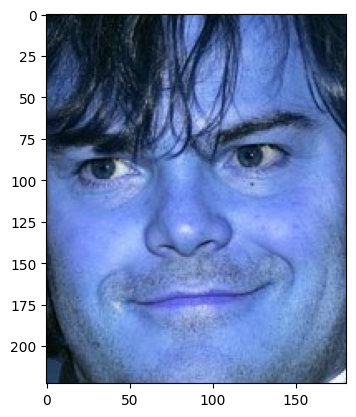

In [11]:
# Instantiate detector object
detector = MTCNN()

def cropFaces(img):
    # detect faces in the image
    faces = detector.detect_faces(img)

    if len(faces) == 0:
        return faces
    x, y, width, height = faces[0]['box']

    return img[y:y+height, x:x+width, :]

# Testing
img = cv2.imread(os.path.join(train_big_data_path,'150.jpg'))
face = cropFaces(img)

# Display the cropped face
plt.imshow(face)
plt.show()

In [12]:
def save_faces(incoming_data_raw, outgoing_faces, image_size):
    '''This function extracts several faces by cropping the images and saves them in a different place.'''
    # Iterate through the original images
    files_list = os.listdir(incoming_data_raw)
    files_list.sort()
 

    for file_name in files_list:
        # Check if the file is an image
        if file_name.endswith('.jpg') or file_name.endswith('.png') or file_name.endswith('.jpeg'):
            original_path = os.path.join(incoming_data_raw, file_name)
            img = cv2.imread(original_path)
            try:
                img_face = cropFaces(img)
                if img_face is None or not isinstance(img_face, np.ndarray):
                    print(f"Error extracting face or no face found at: {original_path}")
                    continue #go to next iteration if there is an error
            except Exception:
                print(f"Error extracting face or no face found at: {original_path}")
                continue #go to next iteration if there is an error
                        
            # Check if a face was found
            if img_face is not None:
                # Resize the face image
                resized_img = cv2.resize(img_face, image_size)

                # Save the resized face image to the processed folder
                processed_path = os.path.join(outgoing_faces, file_name)
                cv2.imwrite(processed_path, resized_img)

In [13]:
# call the function to save the cropped faces
#save_faces(train_big_data_path, train_big_faces_path_MTCNN, image_size)

In [14]:
# call the function to save the cropped faces
#save_faces(test_path, test_faces_path, image_size)

# Create batch for training

In [15]:
def batch_generator(df, batch_size, image_size, classes_dict):
    '''Returns a batch of images and respective labels based on a given batch size and dataframe containing dataset'''
    while True:
        # Iterate over the data in batches
        for i in range(0, len(df), batch_size):
            # Get the next batch of data from the dataframe
            batch_df = df.iloc[i:i + batch_size]
            # Initialize empty lists to store the batch images and labels
            batch_images = []
            batch_labels = []

            # Iterate over each row in the batch of images created above
            for _, row in batch_df.iterrows():
                # Construct the path to the image file
                image_path = os.path.join(data_dir, row['File Name'])
                
                # Read the image from disk using OpenCV
                img = cv2.imread(image_path)
                
                # Check if the image is None (i.e., couldn't be read from disk)
                if img is None:
                    #print(f"Error reading image {image_path}: Image is None")  # Print an error message
                    continue # Skip to the next image
             
                resized_img = cv2.resize(img, image_size)                      # Resize the image to the desired size
              
                scaled_img = resized_img / 255.0                               # Scale the pixel values to the range [0, 1]
        
                label = row['Category']                                        # Get the label for the image from the dataframe
                
                label_num = list(classes_dict.values()).index(label)           # Convert the label to a numeric index using the classes dictionary
                
                label_one_hot = to_categorical(label_num, len(classes_dict))   # Convert the numeric index to a one-hot encoded label vector

                # Add the scaled image and label vector to the batch lists
                batch_images.append(scaled_img)
                batch_labels.append(label_one_hot)
            
            # Convert the batch lists to numpy arrays and yield them
            yield np.array(batch_images), np.array(batch_labels)


## Double check loaded data

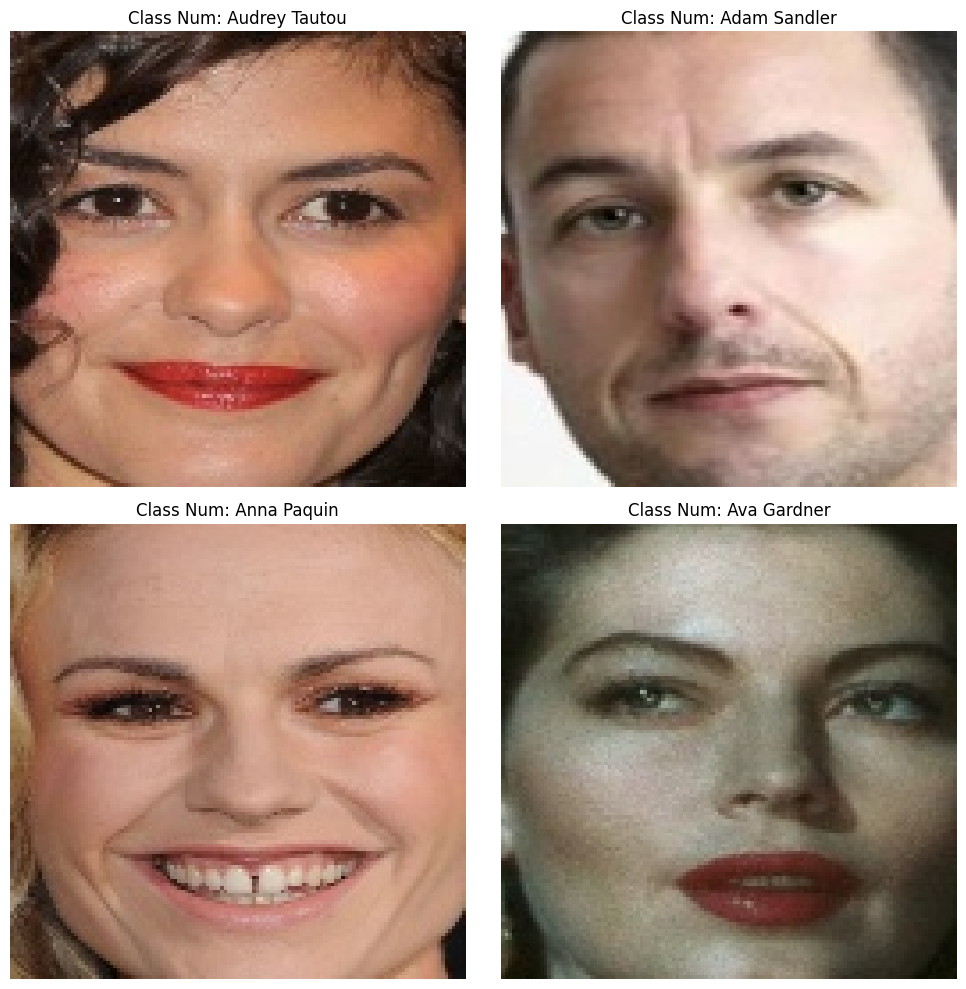

In [16]:
# Grab the next batch of 4 images from the batch generator
selected_images,selected_labels = next(batch_generator(train_data_df, 4, image_size, classes_dict))

#batch = data_iterator.next()          #allows us to get the next batch from the data iterator
#images, labels = batch                #from the batch data, get the labels and images to double check

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

#enumerate for index, zip for the tuple
for idx, (img, label) in enumerate(zip(selected_images, selected_labels)):
    
    #Determine the current subplot
    row, col = idx // 2, idx % 2
    ax = axes[row, col]

    img_np = img.astype(np.float32)            #tensor to float32 numpy array
    #lab_np = label.numpy().decode()                   #tensor to string array numpy

    bgr_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR) #convert image back to BGR format
    ax.imshow(bgr_img)                                 #show the image
    
    # Set the title with the label name
    ax.set_title(f"Class Num: {classes_dict[np.argmax(label)]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# CNN Model

In [17]:
# 80% is training data, 20% is validation data
train_df, val_df = train_test_split(train_data_df, test_size=0.2, random_state=42)

In [18]:
def create_model(lr, lamb_regularizer, batch_norm, dropout):
    # Model definition
    model = Sequential()

    model.add(Conv2D(16, (3,3), padding='same', kernel_regularizer=l2(lamb_regularizer), use_bias=False, input_shape=(image_size[0],image_size[1],3)))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    if dropout:
        model.add(Dropout(0.25)) 

    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(lamb_regularizer), use_bias=False))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    if dropout:
        model.add(Dropout(0.25)) 

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(lamb_regularizer), use_bias=False))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    if dropout:
        model.add(Dropout(0.25)) 

    model.add(Flatten())
    model.add(Dense(100, activation='softmax'))

    if lr:
        # Implement adjustable learning rate with exponential decay
        initial_learning_rate = 0.01
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True)

        # Optimizer uses learning rate schedule specified above
        adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        #adam optimizer and sparse classification loss function being used
        model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  #when using one hot labels
    
    else:
        #adam optimizer and sparse classification loss function being used
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #when using one hot labels


    #model.summary()


    # Create the batch generators
    train_generator = batch_generator(train_df, batch_size, image_size, classes_dict)
    validation_generator = batch_generator(val_df, batch_size, image_size, classes_dict)

    # Train the model using the batches
    steps_per_epoch = len(train_df) // batch_size
    steps_per_epoch = steps_per_epoch 
    validation_steps = len(val_df) // batch_size
    validation_steps = validation_steps 

    print(f"Validation steps:{validation_steps}\nSteps per epoch:{steps_per_epoch}")

    train_logs = os.path.join(root_dir,'logs')
    # Create a TensorBoard callback to log the training progress
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Log all information in tensorboard
    
    # Fitting the model - takes training data batches of 32 images each
    # 1 epoch = 1 run over entire training set of data
    # Pass validation data to see how good in real time model performs

    # loaded_model = load_model('classifier_000_32_30__0175.h5')
    # additional_epochs = 10
    # history = loaded_model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=additional_epochs, verbose=2)


    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    # Fit the model
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=epochs, verbose=2, callbacks=[tensorboard_callback, early_stopping])

    return model, history

In [19]:
'''dropouts = [True, False]
lrs = [True, False]
batch_norms = [True, False]
lambd_regularizers = [0.0001, 0.001, 0.01]
histories = []
params = []
models = []

for dropout in dropouts:
    for lr in lrs:
        for lamb_regularizer in lambd_regularizers:
            for batch_norm in batch_norms:
                model, history = create_model(lr, lamb_regularizer, batch_norm, dropout)
                histories.append(history)
                #OLD ORDER => params.append((dropout, lr, lamb_regularizer, batch_norm))
                params.append((lr, lamb_regularizer, batch_norm, dropout))
                models.append(model)'''

'dropouts = [True, False]\nlrs = [True, False]\nbatch_norms = [True, False]\nlambd_regularizers = [0.0001, 0.001, 0.01]\nhistories = []\nparams = []\nmodels = []\n\nfor dropout in dropouts:\n    for lr in lrs:\n        for lamb_regularizer in lambd_regularizers:\n            for batch_norm in batch_norms:\n                model, history = create_model(lr, lamb_regularizer, batch_norm, dropout)\n                histories.append(history)\n                #OLD ORDER => params.append((dropout, lr, lamb_regularizer, batch_norm))\n                params.append((lr, lamb_regularizer, batch_norm, dropout))\n                models.append(model)'

In [20]:
'''# Plotting results for the best validation accuracy
max_val_accuracies= []
for i, history in enumerate(histories):
    max_val_accuracy = max(history.history['val_accuracy'])
    #print(f'Max_val_accuracy: {max_val_accuracy}\nParams:{params[i]}\n')
    print(params[i])
    max_val_accuracies.append(max_val_accuracy)
    
plt.bar(range(0, len(max_val_accuracies)), max_val_accuracies)
plt.xticks(range(0, len(max_val_accuracies)), params, rotation ='vertical')
plt.xlabel('Instance')
plt.ylabel('Validation Accuracy')
plt.show()'''

"# Plotting results for the best validation accuracy\nmax_val_accuracies= []\nfor i, history in enumerate(histories):\n    max_val_accuracy = max(history.history['val_accuracy'])\n    #print(f'Max_val_accuracy: {max_val_accuracy}\nParams:{params[i]}\n')\n    print(params[i])\n    max_val_accuracies.append(max_val_accuracy)\n    \nplt.bar(range(0, len(max_val_accuracies)), max_val_accuracies)\nplt.xticks(range(0, len(max_val_accuracies)), params, rotation ='vertical')\nplt.xlabel('Instance')\nplt.ylabel('Validation Accuracy')\nplt.show()"

Conclusions for run #1:
- Dropout: True,
- lr: False,
- lambd_regularizer: vary, 
- batch_norm: vary

In [21]:
'''# Running model for the best parameters found above
#True False 0.001 False
#Dropout lr lambd_regularizer batch_norm
best_model, best_history = create_model(False, 0.001, False, True)'''

'# Running model for the best parameters found above\n#True False 0.001 False\n#Dropout lr lambd_regularizer batch_norm\nbest_model, best_history = create_model(False, 0.001, False, True)'

## Test

In [22]:
def predict_test_classes(model):
    # Run through indices and rows of sample submission df (results_data_df)
    for index, tup_row in results_data_df.iterrows():
        test_image_path = os.path.join(test_faces_path, str(tup_row['Id'])+'.jpg')         #Get full path to image of test dataset
        try:
            test_img = cv2.imread(test_image_path) # Read test image with cv2
            if test_img is None:
                print(f"Error reading image {test_image_path}: Image is None")
                continue
            resized_img = cv2.resize(test_img, image_size)            # Resize the test image
            yhat = model.predict(np.expand_dims(resized_img/255, 0))  # Perform prediction
            pred_idx = np.argmax(yhat)                                # Highest value of prediction of y vector's index is predicted numeric label 
            pred_label = classes_dict[pred_idx]                       # Get predicted label (name of celebrity) from dictionary
            results_data_df.loc[index,'Category'] = pred_label        # Update results dataframe
        except Exception as e:
            print(f"One Error reading image {test_image_path}: {e}")

    # Convert updated results dataframe to CSV file
    results_data_df.to_csv(results_save_path, index=False)

In [23]:
#predict_test_classes(best_model)

# Iteration 2 - Cross validation

In [24]:
def create_model_new(initial_lr, lamb_regularizer, batch_norm, dropout_rate, extra_layer='normal'):
    # Model definition
    model = Sequential()

    model.add(Conv2D(16, (3,3), padding='same', kernel_regularizer=l2(lamb_regularizer), use_bias=False, input_shape=(image_size[0],image_size[1],3)))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    if dropout_rate is not False:
        model.add(Dropout(dropout_rate)) 

    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(lamb_regularizer), use_bias=False))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    if dropout_rate is not False:
        model.add(Dropout(dropout_rate)) 

    if extra_layer=='normal' or extra_layer=='more':
        model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(lamb_regularizer), use_bias=False))
        if batch_norm == True:
            model.add(BatchNormalization()) 
        model.add(Activation('relu'))
        model.add(MaxPooling2D())
        if dropout_rate is not False:
            model.add(Dropout(dropout_rate))

        if extra_layer=='more':
            model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(lamb_regularizer), use_bias=False))
            if batch_norm == True:
                model.add(BatchNormalization()) 
            model.add(Activation('relu'))
            model.add(MaxPooling2D())
            if dropout_rate is not False:
                model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(100, activation='softmax'))

    if initial_lr is not False:
        # Implement adjustable learning rate with exponential decay
        initial_learning_rate = initial_lr
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True)

        # Optimizer uses learning rate schedule specified above
        adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        #adam optimizer and sparse classification loss function being used
        model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  #when using one hot labels
    
    else:
        #adam optimizer and sparse classification loss function being used
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #when using one hot labels


    #model.summary()


    # Create the batch generators
    train_generator = batch_generator(train_df, batch_size, image_size, classes_dict)
    validation_generator = batch_generator(val_df, batch_size, image_size, classes_dict)

    # Train the model using the batches
    steps_per_epoch = len(train_df) // batch_size
    steps_per_epoch = steps_per_epoch 
    validation_steps = len(val_df) // batch_size
    validation_steps = validation_steps 

    print(f"Validation steps:{validation_steps}\nSteps per epoch:{steps_per_epoch}")

    train_logs = os.path.join(root_dir,'logs')
    # Create a TensorBoard callback to log the training progress
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Log all information in tensorboard
    
    # Fitting the model - takes training data batches of 32 images each
    # 1 epoch = 1 run over entire training set of data
    # Pass validation data to see how good in real time model performs

    # loaded_model = load_model('classifier_000_32_30__0175.h5')
    # additional_epochs = 10
    # history = loaded_model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=additional_epochs, verbose=2)


    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='min', restore_best_weights=True)

    # Fit the model
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=epochs, verbose=2, callbacks=[tensorboard_callback, early_stopping])

    return model, history

In [25]:
'''model, history = create_model_new(False, 0.0005, False, 0.2)
predict_test_classes(model)'''

'model, history = create_model_new(False, 0.0005, False, 0.2)\npredict_test_classes(model)'

In [26]:
### Cross-validation ###

'''# Initializing parameters
dropout_rates = [0.2, 0.25, 0.3]
initial_lrs = [False, 0.1, 0.05]
batch_norms = [True, False]
lambd_regularizers = [0.005, 0.001, 0.0005]
#extra_layers = ['less', 'normal', 'more']
histories = []
params = []
models = []

# Running model for different combinations of parameters
for dropout_rate in dropout_rates:
    for initial_lr in initial_lrs:
        for lamb_regularizer in lambd_regularizers:
            for batch_norm in batch_norms:
                model, history = create_model_new(initial_lr, lamb_regularizer, batch_norm, dropout_rate)
                histories.append(history)
                params.append((initial_lr, lamb_regularizer, batch_norm, dropout_rate))
                models.append(model)'''

"# Initializing parameters\ndropout_rates = [0.2, 0.25, 0.3]\ninitial_lrs = [False, 0.1, 0.05]\nbatch_norms = [True, False]\nlambd_regularizers = [0.005, 0.001, 0.0005]\n#extra_layers = ['less', 'normal', 'more']\nhistories = []\nparams = []\nmodels = []\n\n# Running model for different combinations of parameters\nfor dropout_rate in dropout_rates:\n    for initial_lr in initial_lrs:\n        for lamb_regularizer in lambd_regularizers:\n            for batch_norm in batch_norms:\n                model, history = create_model_new(initial_lr, lamb_regularizer, batch_norm, dropout_rate)\n                histories.append(history)\n                params.append((initial_lr, lamb_regularizer, batch_norm, dropout_rate))\n                models.append(model)"

In [28]:
best_model, history = create_model_new(False, 0.0005, False, 0.3)
predict_test_classes(best_model)

Validation steps:434
Steps per epoch:1738
Epoch 1/25


\\nas01.itap.purdue.edu\puhome\ecn.data\bad\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1738/1738 - 135s - 78ms/step - accuracy: 0.1626 - loss: 3.9025 - val_accuracy: 0.3349 - val_loss: 3.1718
Epoch 2/25
1738/1738 - 129s - 74ms/step - accuracy: 0.4009 - loss: 2.8309 - val_accuracy: 0.4573 - val_loss: 2.7049
Epoch 3/25
1738/1738 - 123s - 71ms/step - accuracy: 0.5026 - loss: 2.3481 - val_accuracy: 0.5045 - val_loss: 2.5335
Epoch 4/25
1738/1738 - 127s - 73ms/step - accuracy: 0.5630 - loss: 2.0464 - val_accuracy: 0.5113 - val_loss: 2.5152
Epoch 5/25
1738/1738 - 122s - 70ms/step - accuracy: 0.6004 - loss: 1.8455 - val_accuracy: 0.5344 - val_loss: 2.4557
Epoch 6/25
1738/1738 - 128s - 74ms/step - accuracy: 0.6294 - loss: 1.6926 - val_accuracy: 0.5367 - val_loss: 2.4676
Epoch 7/25
1738/1738 - 131s - 76ms/step - accuracy: 0.6538 - loss: 1.5542 - val_accuracy: 0.5570 - val_loss: 2.4005
Epoch 8/25
1738/1738 - 124s - 71ms/step - accuracy: 0.6741 - loss: 1.4492 - val_accuracy: 0.5637 - val_loss: 2.3550
Epoch 9/25
1738/1738 - 123s - 71ms/step - accuracy: 0.6950 - loss: 1.3463 - val_acc

# Appendix

In [17]:
# Model definition
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', kernel_regularizer=l2(0.0001), use_bias=False, input_shape=(image_size[0],image_size[1],3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(0.0001), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.0001), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='softmax'))

\\nas01.itap.purdue.edu\puhome\ecn.data\bad\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
'''# Implement adjustable learning rate with exponential decay
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Optimizer uses learning rate schedule specified above
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)'''

#adam optimizer and sparse classification loss function being used
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #when using one hot labels


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │     1,638,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,420 (6.34 MB)

 Trainable params: 1,662,196 (6.34 MB)

 Non-trainable params: 224 (896.00 B)

In [19]:
# Create the batch generators
train_generator = batch_generator(train_df, batch_size, image_size, classes_dict)
validation_generator = batch_generator(val_df, batch_size, image_size, classes_dict)

# Train the model using the batches
steps_per_epoch = len(train_df) // batch_size
steps_per_epoch = steps_per_epoch 
validation_steps = len(val_df) // batch_size
validation_steps = validation_steps 

print(f"Validation steps:{validation_steps}\nSteps per epoch:{steps_per_epoch}")

train_logs = os.path.join(root_dir,'logs')
# Create a TensorBoard callback to log the training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Log all information in tensorboard

Validation steps:434
Steps per epoch:1738


In [20]:
# Fitting the model - takes training data batches of 32 images each
# 1 epoch = 1 run over entire training set of data
# Pass validation data to see how good in real time model performs

# loaded_model = load_model('classifier_000_32_30__0175.h5')
# additional_epochs = 10
# history = loaded_model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=additional_epochs, verbose=2)


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=epochs, verbose=2, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/25
1738/1738 - 226s - 130ms/step - accuracy: 0.2352 - loss: 3.9660 - val_accuracy: 0.3886 - val_loss: 2.8923
Epoch 2/25
1738/1738 - 222s - 128ms/step - accuracy: 0.5309 - loss: 2.2311 - val_accuracy: 0.4830 - val_loss: 2.5542
Epoch 3/25
1738/1738 - 222s - 128ms/step - accuracy: 0.6929 - loss: 1.4370 - val_accuracy: 0.4871 - val_loss: 2.7288
Epoch 4/25
1738/1738 - 217s - 125ms/step - accuracy: 0.8236 - loss: 0.8059 - val_accuracy: 0.4911 - val_loss: 3.1011
Epoch 5/25
1738/1738 - 216s - 124ms/step - accuracy: 0.8996 - loss: 0.4397 - val_accuracy: 0.5013 - val_loss: 3.2862
Epoch 6/25
1738/1738 - 216s - 124ms/step - accuracy: 0.9304 - loss: 0.2906 - val_accuracy: 0.4024 - val_loss: 4.1290
Epoch 7/25
1738/1738 - 213s - 123ms/step - accuracy: 0.9513 - loss: 0.2199 - val_accuracy: 0.4781 - val_loss: 4.1341
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


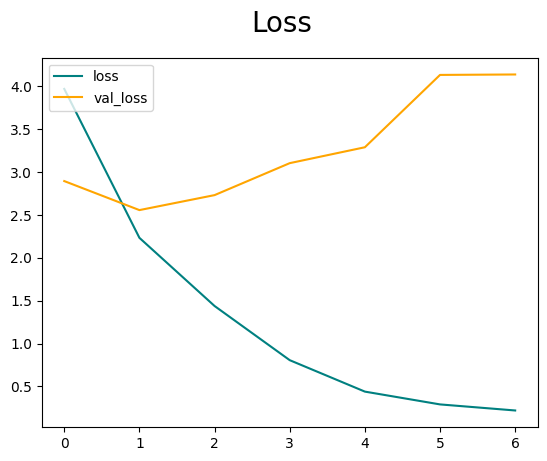

In [21]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

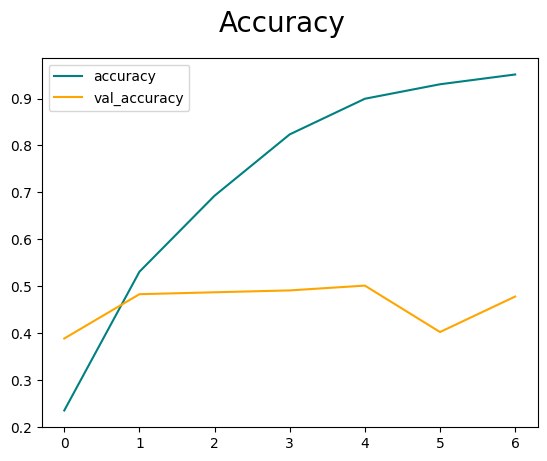

In [22]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Test

In [23]:
# Run through indices and rows of sample submission df (results_data_df)
for index, tup_row in results_data_df.iterrows():
    test_image_path = os.path.join(test_faces_path, str(tup_row['Id'])+'.jpg')         #Get full path to image of test dataset
    try:
        test_img = cv2.imread(test_image_path) # Read test image with cv2
        if test_img is None:
          print(f"Error reading image {test_image_path}: Image is None")
          continue
        resized_img = cv2.resize(test_img, image_size)            # Resize the test image
        yhat = model.predict(np.expand_dims(resized_img/255, 0))  # Perform prediction
        pred_idx = np.argmax(yhat)                                # Highest value of prediction of y vector's index is predicted numeric label 
        pred_label = classes_dict[pred_idx]                       # Get predicted label (name of celebrity) from dictionary
        results_data_df.loc[index,'Category'] = pred_label        # Update results dataframe
    except Exception as e:
        print(f"One Error reading image {test_image_path}: {e}")

# Convert updated results dataframe to CSV file
results_data_df.to_csv(results_save_path, index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━